# Elevation derived textural features

Derive GLCM for the digital height model. Extract slope, laplacian and roughness for all other datasets (DSM, DEM, DHM, fDHM)

In [1]:
# import libraries
# notebook run from myenv environment
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import os

from skimage import io, measure, filters
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.exposure import rescale_intensity, histogram
from skimage.util import img_as_ubyte

from scipy import ndimage
from scipy.stats import entropy
from scipy import signal
from PIL import Image


#### Grey Level Co-Matrix
Derive GLCM for digital height model (DHM) only. The GLCM function only takes three arguments, the input file name (with full path), the window size and level

In [8]:
# get DHM from local drive
dhm = 'C:/Data/atulip/ws/lidar/elevation/ws_upolu_dhm.tif'
output_path = 'C:/Data/atulip/ws/lidar/elevation/texture/'

In [13]:
def GLCM_function(dhm, window_size, lvl):
   # load in DHM raster (elevation-derived)
    with rio.open(dhm, 'r') as src:
        profile = src.profile
        profile['dtype'] = 'int16'
        src_meta = src.meta
        import_file = src.read()
        raster = import_file[0,:,:] # two dimensions required 
    
    # convert float to integer for GLCM
    #outRaster = rescale_intensity(raster, out_range=(0,100)).astype(int)
    #print('data type:', outRaster.dtype)
    
    def GLCM_feat(s_img, window_size, lvl):
            rows, cols = s_img.shape
            Contrast = np.zeros([rows, cols], dtype=np.int8)
            Dissimilarity = np.zeros([rows, cols], dtype=np.int8)
            Correlation = np.zeros([rows, cols], dtype=np.int8)
            Homogeneity = np.zeros([rows, cols], dtype=np.int8)
            Energy = np.zeros([rows, cols], dtype=np.int8)
            ASM = np.zeros([rows, cols], dtype=np.int8)
            
            for i in range(rows - window_size+1):
                # print(i)
                for j in range(cols - window_size+1):
                    window = s_img[i:i+window_size, j:j+window_size]
                    # calculate GLCM 
                    glcm = graycomatrix(window, distances = [1], angles = [0], levels = lvl,
                            symmetric = True, normed = True)
                    # calculate contrast, dissimiliarity, homogeneity, asm, energy and correlation
                    Contrast[i,j] = graycoprops(glcm, 'contrast')[0,0]
                    Dissimilarity[i,j] = graycoprops(glcm, 'dissimilarity')[0,0]
                    Correlation[i,j] = graycoprops(glcm, 'correlation')[0,0]
                    Homogeneity[i,j] = graycoprops(glcm, 'homogeneity')[0,0]
                    Energy[i,j] = graycoprops(glcm, 'energy')[0,0]
                    ASM[i,j] = graycoprops(glcm, 'ASM')[0,0]
            
            return np.stack((Contrast, Dissimilarity, Correlation, Homogeneity, Energy, ASM))
    
    outRaster = img_as_ubyte(raster) 
    print('rescaling image and check shape:', outRaster.shape)    
     # run function to compute GLCM
    output = GLCM_feat(outRaster, window_size, lvl)
    print('completed GLCM calculation for DHM layer')
    # update metadata - count for number of bands
    src_meta.update(
    count = str(output.shape[0]))

    print('writing file')
    # write output
    with rio.open(os.path.join(output_path + 'GLCM.tif'), 'w', **src_meta) as dst:
        dst.write(output)
        dst.close

    return output   

In [14]:
%%timeit
window_size = 5
lvl =  101
output = GLCM_function(dhm, window_size, lvl)

rescaling image and check shape: (4615, 5857)
completed GLCM calculation for DHM layer
writing file
rescaling image and check shape: (4615, 5857)
completed GLCM calculation for DHM layer
writing file
rescaling image and check shape: (4615, 5857)


KeyboardInterrupt: 

##### Split multiband raster into separate bands

In [15]:
# use list to split multiband to single bands
measure = ['Contrast', 'Dissimilarity', 'Correlation', 'Homogeneity', 'Energy', 'ASM']
fp = 'GLCM.tif'

In [16]:
# read in multiband GLCM raster and separate and store in file using this loop
with rio.open(os.path.join(output_path +fp)) as dst:
    print(dst.count)
    meta = dst.meta
 
    
    for i in range(0, len(measure)):
        raster = dst.read(i+1)
        metric = measure[i]
        outpath = os.path.join(output_path + metric + '.tif')
        print('output path: ' + outpath)
        
        # update metadata count
        
        meta.update(count = 1)
                
        #write individual band
        with rio.open(outpath, 'w', **meta) as dest:
            dest.write(raster, 1)
            #dest.descriptions = tuple(metric)
            #dest.close

6
output path: C:/Data/atulip/ws/lidar/elevation/texture/Contrast.tif
output path: C:/Data/atulip/ws/lidar/elevation/texture/Dissimilarity.tif
output path: C:/Data/atulip/ws/lidar/elevation/texture/Correlation.tif
output path: C:/Data/atulip/ws/lidar/elevation/texture/Homogeneity.tif
output path: C:/Data/atulip/ws/lidar/elevation/texture/Energy.tif
output path: C:/Data/atulip/ws/lidar/elevation/texture/ASM.tif


#### Variance and Entropy

In [17]:
# path to get input
window_size = 5

In [18]:
def variance_function(dhm, window_size):
# load in DHM raster (elevation-derived)
    with rio.open(dhm, 'r') as src:
        src_meta = src.meta
        import_file = src.read()
        raster = import_file[0,:,:] # two dimensions required 
    
    # convert float to integer for GLCM
    outRaster = img_as_ubyte(raster)
    # outRaster = rescale_intensity(raster, in_range = (0,131), out_range=(0,100)).astype(int)
    print('data type:', outRaster.dtype)

    Variance = ndimage.generic_filter(outRaster, np.var, size = window_size)
    #w_fn = os.path.join(out_fn + fn[:-8] + "_variance_10m.tif")
    #print(w_fn)
    with rio.open(os.path.join(output_path + 'var.tif'), 'w', **src_meta) as dst:
        dst.write(Variance, 1)
        dst.close

    return Variance

In [20]:
out_variance = variance_function(dhm, window_size)

data type: uint8


In [22]:
def entropy_function(dhm, window_size):
# load in DHM raster (elevation-derived)
    with rio.open(dhm, 'r') as src:
        src_meta = src.meta
        import_file = src.read()
        raster = import_file[0,:,:] # two dimensions required 
    
    # convert float to integer for GLCM
    outRaster = img_as_ubyte(raster)
    # outRaster = rescale_intensity(raster, in_range = (0,131), out_range=(0,100)).astype(int)
    print('data type:', outRaster.dtype)
    Entropy = ndimage.generic_filter(outRaster, entropy, size = window_size)
    print('writing entropy')
    with rio.open(os.path.join(output_path + 'ent.tif'), 'w', **src_meta) as dst:
        dst.write(Entropy, 1)
        dst.close

    return Entropy

In [23]:
out_entropy = entropy_function(dhm, window_size)

data type: uint8
writing entropy


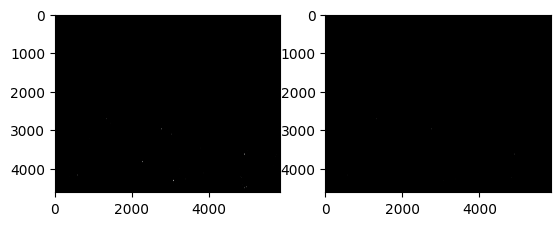

In [24]:
# plot variance and entropy result
fig = plt.figure()
plt.gray()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.imshow(out_variance)
ax1.imshow(out_entropy)
plt.show()

### Density Filter

Still a work in progress. 
Using scipy convolv2 or possibly the generic filter

In [ ]:
with rio.open(dhm, 'r') as src:
        profile = src.profile 
        src_meta = src.meta # get metadata to write resulting dataset
        outRas = src.read()
        outRas = outRas[0,:,:]

In [41]:
# apply gaussian filter
fdhm = ndimage.gaussian_filter(outRas, sigma = 1)

In [42]:
with rio.open(os.path.join(output_path + 'fdhm.tif'), 'w', **src_meta) as dst:
        dst.write(fdhm, 1)
        dst.close

### Sobel Filter and Hystersis Thresholding
To extract canopy signals from the digital height model (DHM). This uses a different algorithm as proposed by Jones et al 2022. Here we apply hystersis - a lagging of an effect, that is known to ignore 'noise' outside of edges. 

This uses skimage.morphology's attribute operators

In [25]:
# dhm = 'C:/Data/atulip/mnre_lidar/data/00_lvl/samoa_dhm_10m.tif'

# load in DHM raster (elevation-derived)
with rio.open(dhm, 'r') as src:
    profile = src.profile
    profile['dtype'] = 'int8'
    src_meta = src.meta
    outRas = src.read()
    outRas = outRas[0,:,:]

In [26]:
outRas.shape

(4615, 5857)

In [27]:
# set edges, high and low thresholds
edges = filters.sobel(outRas, mode = 'mirror' )
edges_s = filters.scharr(outRas)
low = 5
high = 20

In [28]:
lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)
hyst_scarr = filters.apply_hysteresis_threshold(edges_s, low, high)

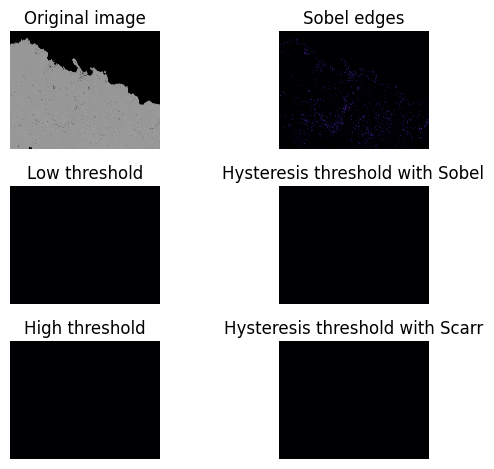

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=2)
ax[0, 0].imshow(outRas, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold with Sobel')

ax[2, 0].imshow(hight, cmap='magma')
ax[2, 0].set_title('High threshold')

ax[2, 1].imshow(hyst_scarr, cmap='magma')
ax[2, 1].set_title('Hysteresis threshold with Scarr')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

In [30]:
# write raster files
# sobel filter
with rio.open(os.path.join(output_path + 'samoa_sobel_5l20h_10m.tif'), 'w', **src_meta) as dst:
        dst.write(hyst, 1)
        dst.close

with rio.open(os.path.join(output_path + 'samoa_scharr_5l20h_10m.tif'), 'w', **src_meta) as dst:
        dst.write(hyst_scarr, 1)
        dst.close

## Non-elevation based Features

Create slope raster grids from DSM, DEM, DHM and fDHM

### Slope raster grid


In [55]:
from osgeo import ogr, gdal

In [57]:
elev_path = 'C:/Data/atulip/ws/lidar/elevation/texture/'
# output_path = 'C:/Data/atulip/mnre_lidar/data/00_lvl/slope/'

dem = "ws_upolu_dem.tif"
dtm = "ws_upolu_dtm.tif"
dhm = "ws_upolu_dhm.tif"
fdhm = "fdhm.tif"

In [58]:
# create gdal slope function
def gdal_slp_ds(fn):
    # correct path for filename
    i_fn = os.path.join(elev_path + fn)
    # path for filename to write
    w_fn = os.path.join(elev_path + fn[:-4] + "_slope.tif")
    print("-------Calculating slope for:", fn, "----------")
    # open file
    elv_ds = gdal.Open(i_fn)
    # select slope as product
    elv_slp = gdal.DEMProcessing(w_fn, elv_ds, "slope", band = 1, alg = "ZevenbergenThorne")
    data = elv_slp.ReadAsArray()
    print("------Completed slope for:", fn, "---------")
    elv_slp = None # close the dataset
    return data

In [59]:
# get slope dataset and output to file
slp_dhm = gdal_slp_ds(fdhm)

-------Calculating slope for: fdhm_3m.tif ----------
------Completed slope for: fdhm_3m.tif ---------


## Textural features
Perform textural analysis to derive roughness and laplacian filter results for DSM, DEM, DHM, fDHM

### Laplacian filter
Run laplacian filter from scipy package

In [60]:
# create gdal slope function
def laplacian_ds(fn):
    # correct path for filename
    i_fn = os.path.join(elev_path + fn)
    # path for filename to write
    w_fn = os.path.join(output_path + fn[:-4] + "_laplacian.tif")
    print("------- loaded data :", fn, "----------")
    
    # open file using rasterio (easier to write)
    with rio.open(i_fn, 'r') as src:
        profile = src.profile
        src_meta = src.meta
        ras = src.read()

    # run laplacian filter
    out_lap = ndimage.laplace(ras, mode = 'reflect')
    print("------Completed Laplacian filter:", fn, "---------")
    
    with rio.open(w_fn, 'w', **src_meta) as dst:
        dst.write(out_lap)
        dst.close

    return out_lap

In [61]:
# run laplacian filter
lap_dem = laplacian_ds(dem)
lap_dtm = laplacian_ds(dtm)
lap_dhm = laplacian_ds(dhm)
lap_fdhm = laplacian_ds(fdhm)

------- loaded data : ws_upolu_dem_3m.tif ----------
------Completed Laplacian filter: ws_upolu_dem_3m.tif ---------
------- loaded data : ws_upolu_dtm_3m.tif ----------
------Completed Laplacian filter: ws_upolu_dtm_3m.tif ---------
------- loaded data : ws_upolu_dhm_3m.tif ----------
------Completed Laplacian filter: ws_upolu_dhm_3m.tif ---------
------- loaded data : fdhm_3m.tif ----------
------Completed Laplacian filter: fdhm_3m.tif ---------


### Roughness raster grids
Apply filter that returns the maximum difference in values between a target pixel and it's eight neighbours (range). There are no direct tools available in scipy or skimage and so a difference grid between a maximum and minimum difference filter is performed, with a user-defined size (set to 3). Alternatively a range filter is available in whitebox tools.

In [65]:
# create gdal slope function
def roughness_ds(fn, size):
    # correct path for filename
    i_fn = os.path.join(elev_path + fn)
    # path for filename to write
    w_fn = os.path.join(output_path + fn[:-4] + "_rough.tif")
    print("------- loaded data :", fn, "----------")
    
    # open file using rasterio (easier to write)
    with rio.open(i_fn, 'r') as src:
        profile = src.profile
        src_meta = src.meta
        ras = src.read()

    # run range filter (roughness filter) using whitebox
    out_max = ndimage.maximum_filter(ras, size)
    out_min = ndimage.minimum_filter(ras, size)
    out_range = out_max - out_min
    print("------Completed Min and Max filter for ", fn, "---------")
    
    with rio.open(w_fn, 'w', **src_meta) as dst:
        dst.write(out_range)
        dst.close

    print("------Export range raster for ", fn, "---------")
    return out_range

In [63]:
# run roughness filter
ro_dem = roughness_ds(dem, 3)
ro_dtm = roughness_ds(dtm, 3)
ro_dhm = roughness_ds(dhm, 3)
ro_fdhm = roughness_ds(fdhm, 3)

------- loaded data : ws_upolu_dem_3m.tif ----------
------Completed Min and Max filter for  ws_upolu_dem_3m.tif ---------
------Export range raster for  ws_upolu_dem_3m.tif ---------
------- loaded data : ws_upolu_dtm_3m.tif ----------
------Completed Min and Max filter for  ws_upolu_dtm_3m.tif ---------
------Export range raster for  ws_upolu_dtm_3m.tif ---------
------- loaded data : ws_upolu_dhm_3m.tif ----------
------Completed Min and Max filter for  ws_upolu_dhm_3m.tif ---------
------Export range raster for  ws_upolu_dhm_3m.tif ---------
------- loaded data : fdhm_3m.tif ----------
------Completed Min and Max filter for  fdhm_3m.tif ---------
------Export range raster for  fdhm_3m.tif ---------


In [64]:
ro_dtm = ro_dtm[0,:,:]
ro_dtm.shape

ro_dhm = ro_dhm[0,:,:]
ro_dhm.shape

(4615, 5857)

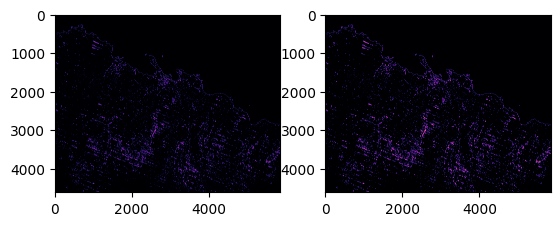

In [66]:
# plot max result filter
fig = plt.figure()
plt.gray()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.imshow(ro_dtm, cmap='magma')
ax1.imshow(ro_dhm, cmap='magma')
plt.show()